## Initial setup

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
!nvidia-smi

Fri Sep 24 17:42:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

     - 10.4 MB 772 kB/s
     |████████████████████████████████| 180 kB 13.1 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████████████████| 139 kB 52.0 MB/s 
     |████████████████████████████████| 97 kB 7.1 MB/s 
     |████████████████████████████████| 70 kB 8.3 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for wandb: filename=wandb-0.8.36-py2.py3-none-any.whl size=1385054 sha256=dfdc72aaa116c981f4dafe6007cb9fef81b80053c466dfbb94a5123c9d8fd3c4
  Stored in directory: /root/.cache/pip/wheels/08/1e/c2/b01dd11de70589ef2c6305c9b94da5bdfa22fd99b08da54fcf
  Created wheel for gql: filename=gql-0.2.0-py3-none-any.whl size=7639 sha256=f8ca5aba49c98b3db5f8e5ca3c64afc4341109d0a9f99662fde08397966c1fb6
  Stored in directory: /root/.cache/pip/wheels/b6/9a/56/5456fd32264a8fc53eefcb2f74e24e99a7ef4eb40a9af5c905
  Created wheel for graphql-core: filename=graphql_core-1.1-py3-none-any.whl size=104649 sha256=b13269ce3fae781a2fe4a5945fc9

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

tf.random.set_seed(666)
np.random.seed(666)

## Dataset gathering and preparation

In [ ]:
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 12.19 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
train_images = list(paths.list_images("imagenet-5-categories/train"))
print(len(train_images))

1250


In [ ]:

class CustomAugment(object):
    def __call__(self, sample):        
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [ ]:
data_augmentation = Sequential([Lambda(CustomAugment())])

In [ ]:
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [ ]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Utilities

In [ ]:
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [ ]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py

--2021-09-24 17:43:27--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]     891  --.-KB/s    in 0s      

2021-09-24 17:43:27 (41.6 MB/s) - ‘helpers.py’ saved [891/891]

--2021-09-24 17:43:28--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘losse

Don't forget to comment the `augmentation` import in the `helpers.py` script.

In [ ]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

In [ ]:
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

In [ ]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [ ]:
wandb.init(project="simclr")

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/user12/simclr/runs/zp2996rl

In [ ]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        wandb.log({"nt_xentloss": np.mean(step_wise_loss)})
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

## Training

  0%|          | 0/200 [00:00<?, ?it/s]wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
  0%|          | 1/200 [01:44<5:45:02, 104.03s/it]

epoch: 1 loss: 3.995


  6%|▌         | 11/200 [12:05<3:31:11, 67.05s/it]

epoch: 11 loss: 2.959


 10%|█         | 21/200 [22:03<2:58:34, 59.86s/it]

epoch: 21 loss: 2.353


 16%|█▌        | 31/200 [31:57<2:47:01, 59.30s/it]

epoch: 31 loss: 2.082


 20%|██        | 41/200 [41:50<2:37:41, 59.51s/it]

epoch: 41 loss: 1.902


 26%|██▌       | 51/200 [51:47<2:28:02, 59.61s/it]

epoch: 51 loss: 1.794


 30%|███       | 61/200 [1:01:41<2:17:29, 59.35s/it]

epoch: 61 loss: 1.716


 36%|███▌      | 71/200 [1:11:34<2:07:37, 59.36s/it]

epoch: 71 loss: 1.662


 40%|████      | 81/200 [1:21:51<1:58:36, 59.81s/it]

epoch: 81 loss: 1.619


 46%|████▌     | 91/200 [1:31:46<1:48:15, 59.59s/it]

epoch: 91 loss: 1.604


 50%|█████     | 101/200 [1:41:40<1:37:57, 59.36s/it]

epoch: 101 loss: 1.581


 56%|█████▌    | 111/200 [1:51:34<1:27:59, 59.32s/it]

epoch: 111 loss: 1.554


 60%|██████    | 121/200 [2:02:15<1:27:43, 66.63s/it]

epoch: 121 loss: 1.531


 66%|██████▌   | 131/200 [2:12:09<1:08:33, 59.61s/it]

epoch: 131 loss: 1.511


 70%|███████   | 141/200 [2:22:03<58:21, 59.34s/it]

epoch: 141 loss: 1.496


 76%|███████▌  | 151/200 [2:31:53<48:09, 58.97s/it]

epoch: 151 loss: 1.491


 80%|████████  | 161/200 [2:41:45<38:36, 59.39s/it]

epoch: 161 loss: 1.490


 86%|████████▌ | 171/200 [2:51:36<28:37, 59.23s/it]

epoch: 171 loss: 1.478


 90%|█████████ | 181/200 [3:01:27<18:44, 59.16s/it]

epoch: 181 loss: 1.473


 96%|█████████▌| 191/200 [3:11:23<08:55, 59.53s/it]

epoch: 191 loss: 1.468


100%|██████████| 200/200 [3:20:19<00:00, 60.10s/it]


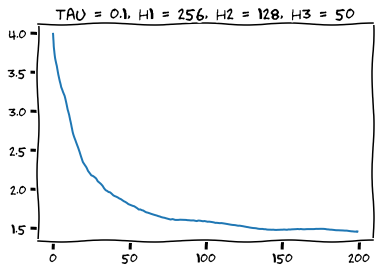

In [ ]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=200)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

In [ ]:
import datetime
filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet_simclr.h5"
filename

'20210924-210444resnet_simclr.h5'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls


20210924-210444resnet_simclr.h5  imagenet-5-categories/  sample_data/
drive/                           losses.py               wandb/
helpers.py                       __pycache__/


In [ ]:
%pwd


'/content'

In [ ]:
%cp -r '/content/20210924-210444resnet_simclr.h5' '/content/drive/MyDrive/Fall2021/297/'